In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malicious-urls-dataset/malicious_phish.csv
/kaggle/input/malicious-url-ml-dataset/urldata.csv
/kaggle/input/detection-dataset/urldata.csv
/kaggle/input/detection-dataset/phishing_site_urls.csv
/kaggle/input/detection-dataset/malicious_phish.csv
/kaggle/input/detection-dataset/data.csv


# 1| IMPORT DEPENDENCIES

In [2]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.8 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install plotly_utils

In [4]:
!pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 5.7 MB/s eta 0:00:00a 0:00:01


In [5]:
!pip install whois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 1.9 MB/s eta 0:00:00


In [6]:
import re
import string
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError

from colorama import Fore
from datetime import datetime
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
from gensim.models import Word2Vec
import tldextract
import hashlib
import whois
import warnings

warnings.filterwarnings("ignore")

# 2| Read the data

In [7]:
url_df = pd.read_csv("/kaggle/input/detection-dataset/urldata.csv")
url_df.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [10]:
url_df = url_df.drop('Unnamed: 0',axis=1)

In [11]:
url_df.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


# 3| Data preprocessing and EDA

In [12]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


In [13]:
url_df.isnull().sum()

url       0
label     0
result    0
dtype: int64

In [14]:
url_df.duplicated().sum()

0

In [15]:
url_df.drop_duplicates(inplace=True)

In [16]:
url_df.duplicated().sum()

0

In [17]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


In [18]:
count = url_df["label"].value_counts()

colors = ['#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D']

fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])
fig.update_layout(
    xaxis_title='Label',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)
fig.update_xaxes(tickfont=dict(color='white'))
fig.update_yaxes(tickfont=dict(color='white'))
fig.show()

In [19]:
url_df["url"] = url_df["url"].replace("www","",regex=True)

url_df.head()

,url,label,result
0,https://.google.com,benign,0
1,https://.youtube.com,benign,0
2,https://.facebook.com,benign,0
3,https://.baidu.com,benign,0
4,https://.wikipedia.org,benign,0


In [20]:
url_df["label"].value_counts()

label
benign       345738
malicious    104438
Name: count, dtype: int64

In [21]:
url_df["url_label"] = url_df["label"].replace({
    'benign': 0,
    'malicious': 1
})

In [22]:
url_df

,url,label,result,url_label
0,https://.google.com,benign,0,0
1,https://.youtube.com,benign,0,0
2,https://.facebook.com,benign,0,0
3,https://.baidu.com,benign,0,0
4,https://.wikipedia.org,benign,0,0
...,...,...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,1
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1
450174,http://atualizapj.com/,malicious,1,1


In [23]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)

In [24]:
url_df['url_len'] = url_df['url'].apply(lambda x: get_url_length(str(x)))

In [25]:
url_df

,url,label,result,url_label,url_len
0,https://.google.com,benign,0,0,11
1,https://.youtube.com,benign,0,0,12
2,https://.facebook.com,benign,0,0,13
3,https://.baidu.com,benign,0,0,10
4,https://.wikipedia.org,benign,0,0,14
...,...,...,...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,1,36
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,152
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,140
450174,http://atualizapj.com/,malicious,1,1,15


In [26]:
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [27]:
url_df['pri_domain'] = url_df['url'].apply(lambda x: extract_pri_domain(x))

In [28]:
url_df

,url,label,result,url_label,url_len,pri_domain
0,https://.google.com,benign,0,0,11,.google.com
1,https://.youtube.com,benign,0,0,12,.youtube.com
2,https://.facebook.com,benign,0,0,13,.facebook.com
3,https://.baidu.com,benign,0,0,10,.baidu.com
4,https://.wikipedia.org,benign,0,0,14,.wikipedia.org
...,...,...,...,...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,1,36,ecct-it.com
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,152,faboleena.com
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,140,faboleena.com
450174,http://atualizapj.com/,malicious,1,1,15,atualizapj.com


In [29]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = set(string.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

In [30]:
url_df['letters_count'] = url_df['url'].apply(lambda x: count_letters(x))
url_df['digits_count'] = url_df['url'].apply(lambda x: count_digits(x))
url_df['special_chars_count'] = url_df['url'].apply(lambda x: count_special_chars(x))

In [31]:
url_df

,url,label,result,url_label,url_len,pri_domain,letters_count,digits_count,special_chars_count
0,https://.google.com,benign,0,0,11,.google.com,14,0,5
1,https://.youtube.com,benign,0,0,12,.youtube.com,15,0,5
2,https://.facebook.com,benign,0,0,13,.facebook.com,16,0,5
3,https://.baidu.com,benign,0,0,10,.baidu.com,13,0,5
4,https://.wikipedia.org,benign,0,0,14,.wikipedia.org,17,0,5
...,...,...,...,...,...,...,...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,1,36,ecct-it.com,34,0,9
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,152,faboleena.com,118,21,20
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,140,faboleena.com,109,20,18
450174,http://atualizapj.com/,malicious,1,1,15,atualizapj.com,17,0,5


In [32]:
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    
    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'short', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd', 
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur', 
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is', 
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl', 
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0

In [33]:
url_df['shortened']  = url_df['url'].apply(lambda x: has_shortening_service(x))

In [34]:
url_df.head()

,url,label,result,url_label,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened
0,https://.google.com,benign,0,0,11,.google.com,14,0,5,0
1,https://.youtube.com,benign,0,0,12,.youtube.com,15,0,5,0
2,https://.facebook.com,benign,0,0,13,.facebook.com,16,0,5,0
3,https://.baidu.com,benign,0,0,10,.baidu.com,13,0,5,0
4,https://.wikipedia.org,benign,0,0,14,.wikipedia.org,17,0,5,0


In [35]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc,url)
        
        if match:
            return 1
    return 0

In [36]:
import re
from urllib.parse import urlparse

def abnormal_url(url):
    netloc = urlparse(url).netloc
    if netloc:
        netloc = str(netloc)
        
        match = re.search(re.escape(netloc), url)
        if match:
            return 1
    return 0

In [37]:
url_df["abnormal_url"] = url_df["url"].apply(lambda x: abnormal_url(x))

In [38]:
url_df

,url,label,result,url_label,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url
0,https://.google.com,benign,0,0,11,.google.com,14,0,5,0,1
1,https://.youtube.com,benign,0,0,12,.youtube.com,15,0,5,0,1
2,https://.facebook.com,benign,0,0,13,.facebook.com,16,0,5,0,1
3,https://.baidu.com,benign,0,0,10,.baidu.com,13,0,5,0,1
4,https://.wikipedia.org,benign,0,0,14,.wikipedia.org,17,0,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,1,36,ecct-it.com,34,0,9,0,1
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,152,faboleena.com,118,21,20,0,1
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,140,faboleena.com,109,20,18,0,1
450174,http://atualizapj.com/,malicious,1,1,15,atualizapj.com,17,0,5,0,1


In [39]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

In [40]:
url_df['secure_http']  = url_df['url'].apply(lambda x: secure_http(x))

In [41]:
import ipaddress
def have_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass  # Invalid hostname or IP address

    return 0

In [42]:
url_df['have_ip']  = url_df['url'].apply(lambda x: have_ip_address(x))

In [43]:
url_df

,url,label,result,url_label,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,https://.google.com,benign,0,0,11,.google.com,14,0,5,0,1,1,0
1,https://.youtube.com,benign,0,0,12,.youtube.com,15,0,5,0,1,1,0
2,https://.facebook.com,benign,0,0,13,.facebook.com,16,0,5,0,1,1,0
3,https://.baidu.com,benign,0,0,10,.baidu.com,13,0,5,0,1,1,0
4,https://.wikipedia.org,benign,0,0,14,.wikipedia.org,17,0,5,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450171,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious,1,1,36,ecct-it.com,34,0,9,0,1,0,0
450172,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,152,faboleena.com,118,21,20,0,1,0,0
450173,http://faboleena.com/js/infortis/jquery/plugin...,malicious,1,1,140,faboleena.com,109,20,18,0,1,0,0
450174,http://atualizapj.com/,malicious,1,1,15,atualizapj.com,17,0,5,0,1,0,0


In [44]:
url_df.isnull().sum()

url                       0
label                     0
result                    0
url_label                 0
url_len                   0
pri_domain             4698
letters_count             0
digits_count              0
special_chars_count       0
shortened                 0
abnormal_url              0
secure_http               0
have_ip                   0
dtype: int64

In [45]:
url_df.fillna(0,inplace=True)

In [46]:
url_df.isnull().sum()

url                    0
label                  0
result                 0
url_label              0
url_len                0
pri_domain             0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
dtype: int64

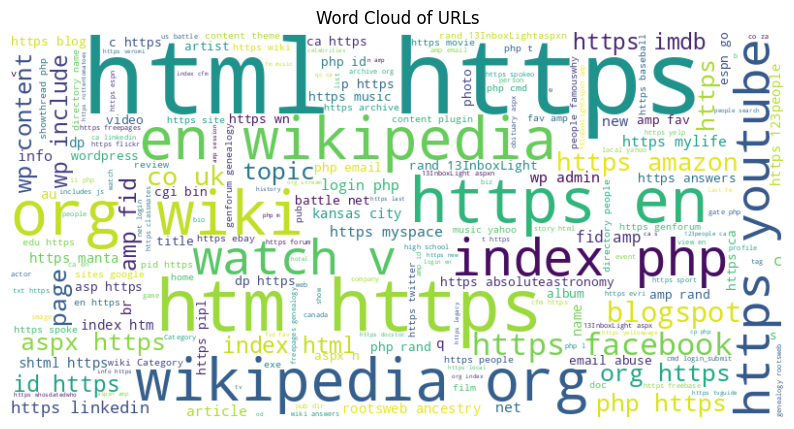

In [47]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(url_df['url']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

In [48]:
# Histogram
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Histogram(x=url_df['url_len'], nbinsx=100))

fig.update_layout(
    title='Distribution of URL Lengths',
    xaxis_title='URL Length',
    yaxis_title='Count',
    template='plotly_dark',
    font=dict(color='white')
)

fig.show()

In [49]:
# Bar chart for 'type' column
label_counts = url_df['label'].value_counts()
fig = go.Figure(data=[go.Bar(x=label_counts.index, y=label_counts.values)])
fig.update_layout(title='Frequency of URL Label',
                  xaxis_title='URL Label',
                  yaxis_title='Count',
                  template='plotly_dark',
                  font=dict(color='white'),
                  showlegend=False)
fig.show()

In [50]:
# Pie chart for 'url_type' column
url_label_counts = url_df['url_label'].value_counts()
fig = go.Figure(data=[go.Pie(labels=url_label_counts.index, values=url_label_counts.values)])
fig.update_layout(title='Distribution of URL Label',
                  template='plotly_dark',
                  font=dict(color='white'),
                  showlegend=True)
fig.show()

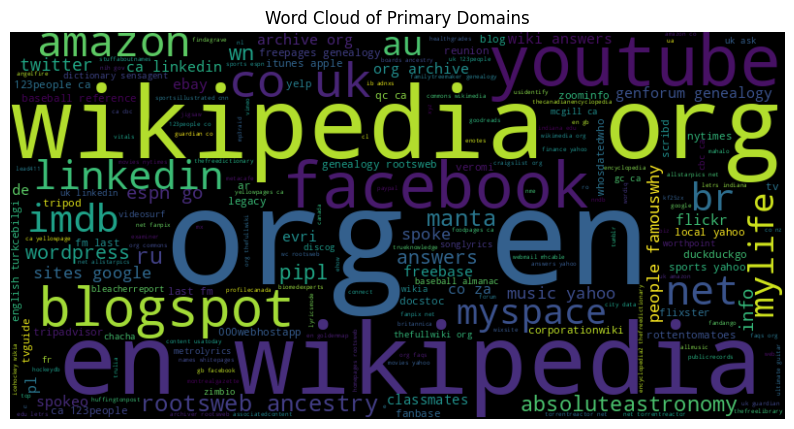

In [51]:
# Convert pri_domain values to strings and filter out None and int values
filtered_domains = url_df['pri_domain'].map(str).dropna()

# Concatenate all pri_domain values into a single string
text = ' '.join(filtered_domains)

# Generate the WordCloud data
wordcloud = WordCloud(background_color='black', colormap='viridis', width=800, height=400).generate(text)

# Plot the WordCloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Primary Domains', color='black')
plt.show()

In [52]:
counts = url_df[['letters_count', 'digits_count', 'special_chars_count']].sum()

fig = go.Figure(data=[
    go.Bar(name='Letters', x=['Count'], y=[counts['letters_count']]),
    go.Bar(name='Digits', x=['Count'], y=[counts['digits_count']]),
    go.Bar(name='Special Characters', x=['Count'], y=[counts['special_chars_count']])
])

fig.update_layout(title='Counts of Letters, Digits, and Special Characters',
                  xaxis_title='Label',
                  yaxis_title='Count',
                  barmode='group',
                  template='plotly_dark',
                  font=dict(color='white'))

fig.show()

In [53]:
true_color = 'green'

false_color = 'red'

shortened_counts = url_df['shortened'].value_counts()
colors = [true_color if val else false_color for val in shortened_counts.index]
fig_shortened = go.Figure(data=go.Bar(x=shortened_counts.index, y=shortened_counts, marker_color=colors))
fig_shortened.update_layout(title='Counts of shortened',
                            xaxis_title='Value',
                            yaxis_title='Count',
                            template='plotly_dark',
                            font=dict(color='white'))
fig_shortened.show()

abnormal_url_counts = url_df['abnormal_url'].value_counts()
colors = [true_color if val else false_color for val in abnormal_url_counts.index]
fig_abnormal_url = go.Figure(data=go.Bar(x=abnormal_url_counts.index, y=abnormal_url_counts, marker_color=colors))
fig_abnormal_url.update_layout(title='Counts of abnormal_url',
                               xaxis_title='Value',
                               yaxis_title='Count',
                               template='plotly_dark',
                               font=dict(color='white'))
fig_abnormal_url.show()

secure_http_counts = url_df['secure_http'].value_counts()
colors = [true_color if val else false_color for val in secure_http_counts.index]
fig_secure_http = go.Figure(data=go.Bar(x=secure_http_counts.index, y=secure_http_counts, marker_color=colors))
fig_secure_http.update_layout(title='Counts of secure_http',
                              xaxis_title='Value',
                              yaxis_title='Count',
                              template='plotly_dark',
                              font=dict(color='white'))
fig_secure_http.show()

have_ip_counts = url_df['have_ip'].value_counts()
colors = [true_color if val else false_color for val in have_ip_counts.index]
fig_have_ip = go.Figure(data=go.Bar(x=have_ip_counts.index, y=have_ip_counts, marker_color=colors))
fig_have_ip.update_layout(title='Counts of have_ip',
                          xaxis_title='Value',
                          yaxis_title='Count',
                          template='plotly_dark',
                          font=dict(color='white'))
fig_have_ip.show()

In [54]:
numeric_data = url_df.select_dtypes(include='number')

corr_matrix = numeric_data.corr()

heatmap = go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Greys',  
)


layout = go.Layout(
    title='Correlation Heatmap (Numeric Values Only)',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    plot_bgcolor='black', 
    paper_bgcolor='black', 
    font=dict(color='white')  
)


fig = go.Figure(data=heatmap, layout=layout)


fig.show()

In [55]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"

In [56]:
url_df['url_region'] = url_df['pri_domain'].apply(lambda x: get_url_region(str(x)))

In [57]:
url_df.head()

,url,label,result,url_label,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region
0,https://.google.com,benign,0,0,11,.google.com,14,0,5,0,1,1,0,Global
1,https://.youtube.com,benign,0,0,12,.youtube.com,15,0,5,0,1,1,0,Global
2,https://.facebook.com,benign,0,0,13,.facebook.com,16,0,5,0,1,1,0,Global
3,https://.baidu.com,benign,0,0,10,.baidu.com,13,0,5,0,1,1,0,Global
4,https://.wikipedia.org,benign,0,0,14,.wikipedia.org,17,0,5,0,1,1,0,Global


In [58]:
region_counts = url_df['url_region'].value_counts()

if 'Global' not in region_counts.index:
    region_counts['Global'] = 0

data = pd.DataFrame({'region': region_counts.index, 'count': region_counts.values})

colorscale = 'YlOrRd'  

fig = go.Figure(data=go.Choropleth(
    locations=data['region'],
    z=data['count'],
    locationmode='country names',
    colorscale=colorscale,
    autocolorscale=True,  
    marker_line_color='white',
    colorbar_title='Count'
))


fig.update_layout(title_text='Distribution of URL Regions')

fig.show()

In [59]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

In [60]:
url_df['root_domain'] = url_df['pri_domain'].apply(lambda x: extract_root_domain(str(x)))

In [61]:
url_df.isnull().sum()

url                    0
label                  0
result                 0
url_label              0
url_len                0
pri_domain             0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
url_region             0
root_domain            0
dtype: int64

In [62]:
url_df.shape

(450176, 15)

In [63]:
url_df.duplicated().sum()

0

In [64]:
url_df.drop_duplicates(inplace=True)

In [65]:
url_df.columns

Index(['url', 'label', 'result', 'url_label', 'url_len', 'pri_domain',
       'letters_count', 'digits_count', 'special_chars_count', 'shortened',
       'abnormal_url', 'secure_http', 'have_ip', 'url_region', 'root_domain'],
      dtype='object')

In [66]:
data = url_df.drop(columns=['url','label','pri_domain'])
data.head()

,result,url_label,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,0,0,11,14,0,5,0,1,1,0,Global,google
1,0,0,12,15,0,5,0,1,1,0,Global,youtube
2,0,0,13,16,0,5,0,1,1,0,Global,facebook
3,0,0,10,13,0,5,0,1,1,0,Global,baidu
4,0,0,14,17,0,5,0,1,1,0,Global,wikipedia


In [67]:
data['root_domain'].value_counts()

root_domain
wikipedia      12895
youtube         8627
facebook        8279
blogspot        7287
amazon          5209
               ...  
funkmysoul         1
funk54             1
funk               1
funinthesun        1
funnybook          1
Name: count, Length: 127761, dtype: int64

In [68]:
data = data[data['root_domain'] != '0']

In [69]:
data['root_domain'].value_counts()

root_domain
wikipedia                12895
youtube                   8627
facebook                  8279
blogspot                  7287
amazon                    5209
                         ...  
funkstown                    1
funkmysoul                   1
funk54                       1
funk                         1
funnycommercialsworld        1
Name: count, Length: 127760, dtype: int64

In [70]:
len(data['root_domain'].value_counts())

127760

In [71]:
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [72]:
data['root_domain'] = data['root_domain'].apply(hash_encode)
data['url_region'] = data['url_region'].apply(hash_encode)

In [73]:
data.head()

,result,url_label,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,0,0,11,14,0,5,0,1,1,0,32604616,83981562
1,0,0,12,15,0,5,0,1,1,0,32604616,70606721
2,0,0,13,16,0,5,0,1,1,0,32604616,61727577
3,0,0,10,13,0,5,0,1,1,0,32604616,38259078
4,0,0,14,17,0,5,0,1,1,0,32604616,41540124


In [74]:
data.shape

(445478, 12)

In [75]:
data.isnull().sum()

result                 0
url_label              0
url_len                0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
url_region             0
root_domain            0
dtype: int64

In [76]:
x = data.drop(columns=["url_label"])
y = data["url_label"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

# 4| Model development

In [77]:
print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (311834, 11)
Y_train Shape : (311834,)
X_test  Shape : (133644, 11)
Y_test  Shape : (133644,)


In [78]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    ExtraTreesClassifier(),
    GaussianNB()
]

In [79]:
results = []
for classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    scores = cross_val_score(pipeline, x, y, cv=2, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, x, y, cv=2)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted', zero_division=1) 
    f1 = f1_score(y, y_pred, average='weighted')
    results.append((classifier.__class__.__name__, accuracy, recall, precision, f1))

In [80]:
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])
results = results.sort_values(by='Accuracy', ascending=False)
results.head()

,Classifier,Accuracy,Recall,Precision,F1-Score
0,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
2,AdaBoostClassifier,1.000000,1.000000,1.000000,1.000000
4,ExtraTreesClassifier,1.000000,1.000000,1.000000,1.000000
5,GaussianNB,0.775394,0.775394,0.731638,0.731661


In [81]:
pipeline = Pipeline([
        ('classifier', ExtraTreesClassifier())
    ])
pipeline.fit(x_train,y_train)

Pipeline(steps=[('classifier', ExtraTreesClassifier())])

In [82]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    103486
           1       1.00      1.00      1.00     30158

    accuracy                           1.00    133644
   macro avg       1.00      1.00      1.00    133644
weighted avg       1.00      1.00      1.00    133644



In [83]:
import joblib
joblib.dump(pipeline,'eTc.sav')

['eTc.sav']

In [84]:
fig = go.Figure(data=go.Table(
    header=dict(values=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                fill_color='black',
                font=dict(color='white'),
                align='center'),
    cells=dict(values=[results['Classifier'], results['Accuracy'], results['Precision'],
                       results['Recall'], results['F1-Score']],
               fill_color='black',
               font=dict(color='white'),
               align='center')))

fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'))

fig.show()

In [85]:
for column in results.columns:
    fig = go.Figure(data=go.Bar(
        x=results['Classifier'],
        y=results[column],
        marker=dict(color='steelblue'),
        text=results[column],
        textposition='auto'
    ))

    fig.update_layout(
        title_text=column,
        xaxis_title='Model',
        yaxis_title=column,
        plot_bgcolor='rgb(17,17,17)',  
        paper_bgcolor='rgb(17,17,17)',
        font=dict(color='white') 
    )


    fig.show()

In [86]:
def get_numerical_values(url):
    url = url.replace('www.', '')
    url_len = get_url_length(url)
    letters_count = count_letters(url)
    digits_count  = count_digits(url)
    special_chars_count = count_special_chars(url)
    shortened = has_shortening_service(url)
    abnormal = abnormal_url(url)
    secure_https = secure_http(url)
    have_ip = have_ip_address(url)
    
    parsed_url  = urlparse(url)
    root_domain = parsed_url.netloc.split(".")[-2]
    url_region = get_url_region(root_domain)
    
    return {
        'url_len': url_len,
        'letters_count': letters_count,
        'digits_count': digits_count,
        'special_chars_count': special_chars_count,
        'shortened': shortened,
        'abnormal': abnormal,
        'secure_http': secure_https,
        'have_ip': have_ip,
        'url_region': hash_encode(url_region),
        'root_domain': hash_encode(root_domain)
    }

def get_url_length(url):
    return len(url)
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits
def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net')
    match = pattern.search(url)
    return int(bool(match))
def abnormal_url(url):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname:
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
    return 0
def secure_http(url):
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 1
    else:
        return 0
def have_ip_address(url):
    pattern = r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' \
              r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|' \
              r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|' \
              r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'

    match = re.search(pattern, url)
    if match:
        return 1
    else:
        return 0
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [87]:
def model_predict(url):
    class_mapping = {
        0: 'benign',
        1: 'maliciuos'
    }
    numerical_values = get_numerical_values(url)
    prediction_int = pipeline.predict(np.array(list(numerical_values.values())).reshape(1, -1))[0]
    prediction_label = class_mapping.get(prediction_int, 'Unknown')
    return prediction_int, prediction_label

In [88]:
url = "https://www.example.com"
numerical_values = get_numerical_values(url)
print(numerical_values)
print(len(numerical_values))
print(list(numerical_values.values()))
print(model_predict(url)[0],model_predict(url)[1])

{'url_len': 19, 'letters_count': 15, 'digits_count': 0, 'special_chars_count': 4, 'shortened': 0, 'abnormal': 1, 'secure_http': 1, 'have_ip': 0, 'url_region': 32604616, 'root_domain': 69889075}
10
[19, 15, 0, 4, 0, 1, 1, 0, 32604616, 69889075]


ValueError: X has 10 features, but ExtraTreesClassifier is expecting 11 features as input.

## This is the longest project i have done and i have learned many things upvotes##